In [1]:
import pandas as pd
import numpy as np

In [2]:
from datetime import datetime

# Data Preparation

In [3]:
data = pd.read_csv("./data/simulated_transaction_2024.csv")

In [4]:
data["Account No"] = data["Account No"].apply(lambda x: int(x) if x >= 0 else -1)
data["Third Party Account No"] = data["Third Party Account No"].apply(lambda x: int(x) if x >= 0 else -1)
data["Third Party Name"] = data["Third Party Name"].apply(lambda x: x if type(x) != float else "Unknow")

In [5]:
purchase_data = data[data['Third Party Name'] != 'Unknow']
purchase_data = purchase_data.dropna()
purchase_data = purchase_data[purchase_data['Amount'] < 0].reset_index().drop(['index','Third Party Account No'],axis=1)
purchase_data['Amount'] = -purchase_data['Amount']

In [6]:
display(purchase_data.tail())

,Date,Timestamp,Account No,Balance,Amount,Third Party Name
215551,06/12/2023,20:54,581655972,45935.206861,41.06,Tesco
215552,06/12/2023,20:55,786141370,-244.837500,62.35,Sainsbury Local
215553,06/12/2023,21:05,824916823,9709.172159,32.94,Deliveroo
215554,06/12/2023,21:13,366550080,26834.165794,19.25,Amazon
215555,06/12/2023,21:32,259015404,1145.349837,37.64,JustEat


In [7]:
category_map = {
    
    # Entertainment
    'Blizzard': 'Entertainment',
    'Xbox': 'Entertainment',
    'Mojang Studios': 'Entertainment',
    'Disney': 'Entertainment',
    'Netflix': 'Entertainment',
    'SquareOnix': 'Entertainment',
    'CeX': 'Entertainment',
    'Gamestation': 'Entertainment',
    'Collector Cave': 'Entertainment',
    'HMV': 'Entertainment',
    'Barbiee Boutique': 'Entertainment',
    
    # Food
    'Deliveroo': 'Food',
    'JustEat': 'Food',
    'Starbucks': 'Food',
    'Coffee #1': 'Food',
    'Costa Coffee': 'Food',
    'Frankie & Bennies': 'Food',
    'Rose & Crown': 'Food',
    'The Crown': 'Food',
    
    
    # Retail
    'Tesco': 'Retail',
    'Sainsbury Local': 'Retail',
    'Coop Local': 'Retail',
    'Sainsbury': 'Retail',
    'Amazon': 'Retail',
    'The Works': 'Retail',
    'Blackwell\'s': 'Retail',
    'Fat Face': 'Retail',
    'Topshop': 'Retail',
    'Matalan': 'Retail',
    'Foyles': 'Retail',
    'Hobby Lobby': 'Retail',
    'Sports Direct': 'Retail',
    'Cass Art': 'Retail',
    'Gap Kids': 'Retail',
    'North Face': 'Retail',
    'Millets': 'Retail',
    'Selfridges': 'Retail',
    'Wool': 'Retail',
    'Revella': 'Retail',
    'Hobbycraft': 'Retail',
    'Etsy': 'Retail',
    'Boots': 'Retail',
    'Reebok': 'Retail',
    'JD Sports': 'Retail',
    'Head': 'Retail',
    'Mamas & Papas': 'Retail',
    'Mountain Warehouse': 'Retail',
    'Pets Corner': 'Retail',
    'Mothercare': 'Retail',
    'A Yarn Story': 'Retail',
    'Craftastic': 'Retail',
    'Loosely Fitted': 'Retail',
    'AMAZON': 'Retail',
    'Lloyds Pharmacy': 'Retail',
    
    # Service
    'Halifax': 'Service',
    'LBG': 'Service',
    'PureGym': 'Service',
    'Specsavers': 'Service',
    'Vision Express': 'Service',
    'Remedy plus care': 'Service',
    'A Cut Above': 'Service',
    'Kew House': 'Service',
    'University College Hospital': 'Service',
    'Happy Days Home': 'Service',
    
    # Travel
    'Kings Arms': 'Travel',
    
    # Other
    'Grand Union BJJ': 'Other',
    'Lavender Primary': 'Other',
    'Victoria Park': 'Other',
    'Stitch By Stitch': 'Other',
    'Fitted Stitch': 'Other',
    'Five Senses Art': 'Other',
    'Brilliant Brushes': 'Other',
    'RugbyFields': 'Other',
    'Town High': 'Other',
}

In [8]:
purchase_data['Hour'] = purchase_data['Timestamp'].apply(lambda x: int(x[:2]))
purchase_data['Month'] = purchase_data['Date'].apply(lambda x: int(x[3:5]))
purchase_data['Date'] = purchase_data['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
purchase_data['Day'] = purchase_data['Date'].apply(lambda x: x.strftime("%A"))
purchase_data['Category'] = purchase_data['Third Party Name'].apply(lambda x: category_map[x])
purchase_data = purchase_data.drop(['Timestamp'], axis=1)

# Correlation Analysis

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [10]:
Category_counts = purchase_data['Category'].value_counts()

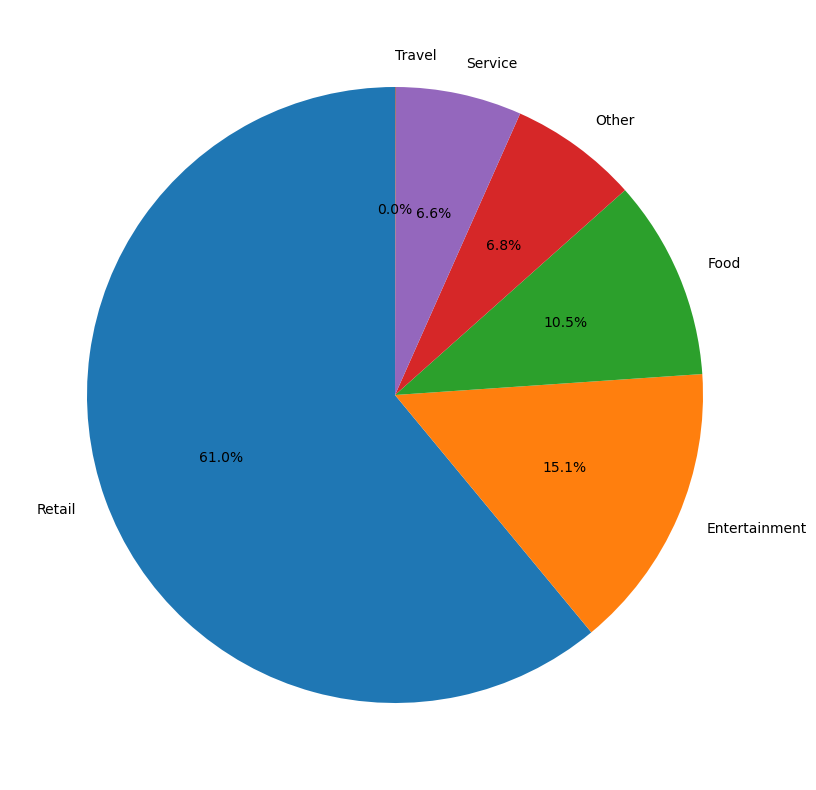

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
labels = list(Category_counts.index)

ax.pie(Category_counts,labels=labels, autopct='%1.1f%%', 
              startangle=90)
    
plt.tight_layout()

In [12]:
from scipy.stats import chi2_contingency

In [13]:
def calculate_cramers_v(df, cat_features, target_feature):
    result = pd.DataFrame(index=cat_features, columns=['Cramers_V', 'p_value'])
    
    for cat_feature in cat_features:
        contingency_table = pd.crosstab(df[cat_feature], df[target_feature])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        
        n = contingency_table.sum().sum()
        k, r = contingency_table.shape
        cramers_v = (chi2 / n) ** 0.5 / min((k-1), (r-1)) ** 0.5
        
        result.loc[cat_feature, 'Cramers_V'] = cramers_v
        result.loc[cat_feature, 'p_value'] = p
    
    return result

In [14]:
def calculate_cramers_v_matrix(df, cat_features):
    result = pd.DataFrame(index=cat_features, columns=cat_features)
    
    for cat_feature_row in cat_features:
        for cat_feature_col in cat_features:
            contingency_table = pd.crosstab(df[cat_feature_row], df[cat_feature_col])
            chi2, _, _, _ = chi2_contingency(contingency_table)

            n = contingency_table.sum().sum()
            k, r = contingency_table.shape
            cramers_v = (chi2 / n) ** 0.5 / min((k-1), (r-1)) ** 0.5

            result.loc[cat_feature_row, cat_feature_col] = cramers_v
    
    return result

Text(0.5, 1.0, 'Hour Distribution')

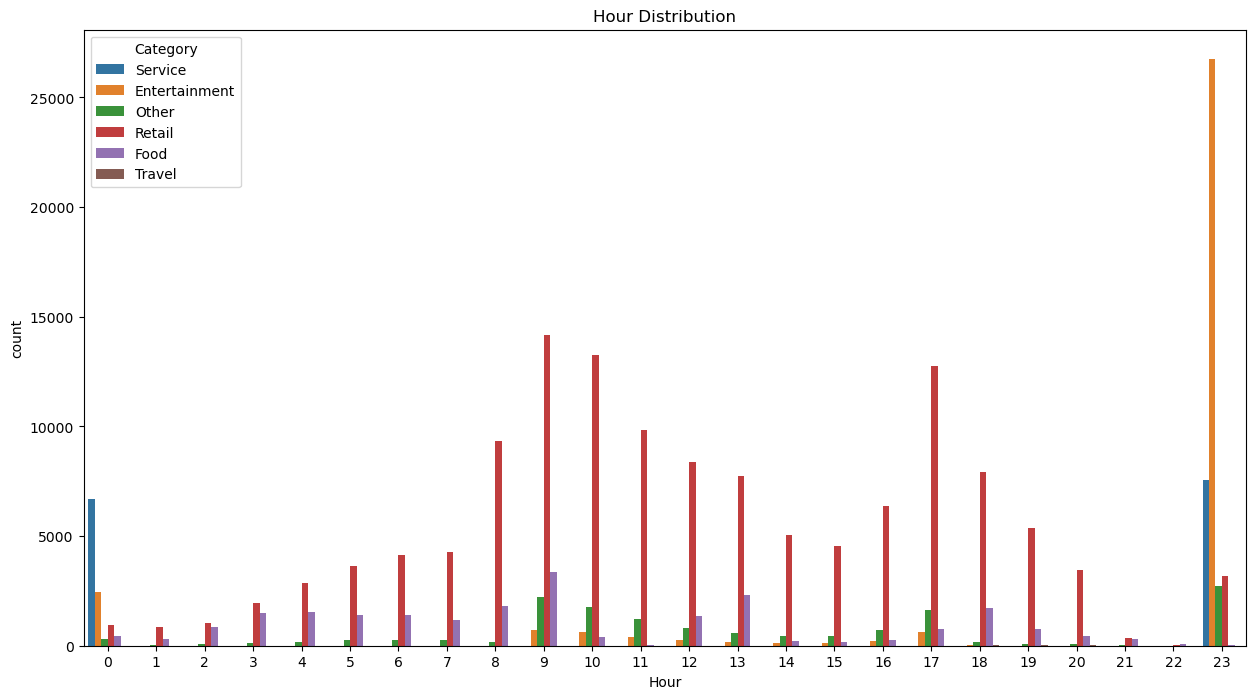

In [15]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(data=purchase_data, x='Hour', hue='Category', ax=ax)
#ax.set_xticks(range(0, 24, 1))
ax.set_title('Hour' + " Distribution")

Text(0.5, 1.0, 'Day Distribution')

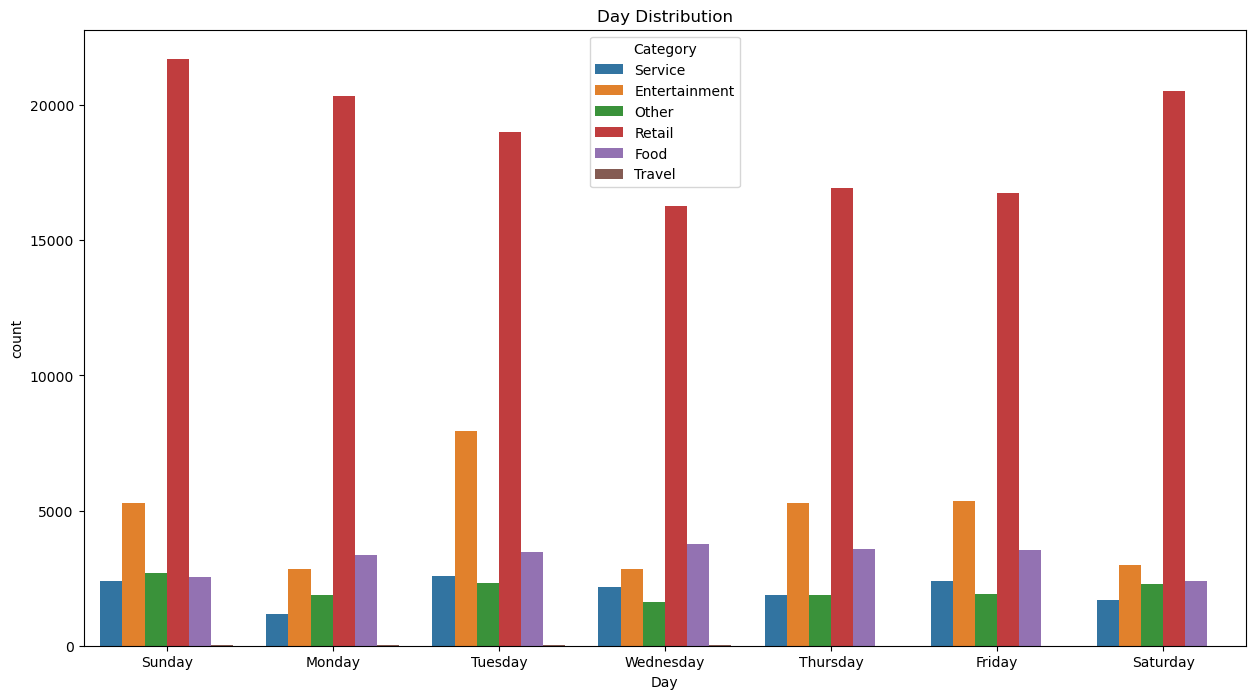

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(data=purchase_data, x='Day', hue='Category', ax=ax)
# ax.set_xticks(range(0, 24, 1))
ax.set_title('Day' + " Distribution")

Text(0.5, 1.0, 'Month Distribution')

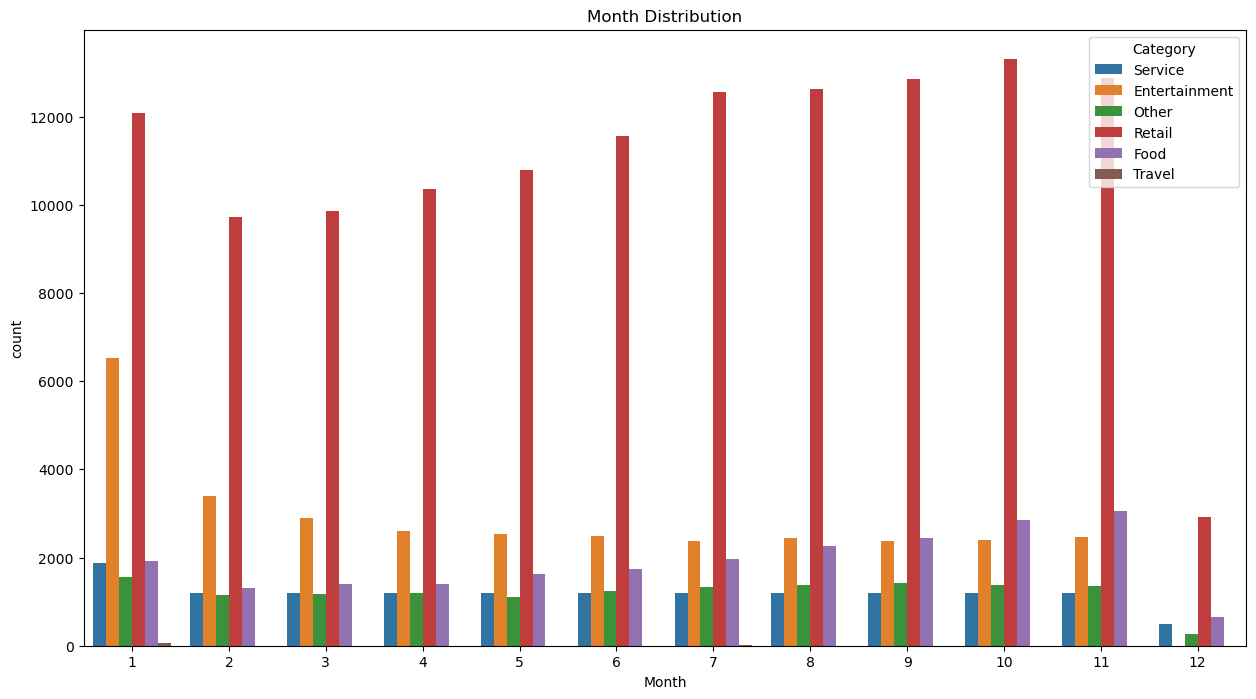

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(data=purchase_data, x='Month', hue='Category', ax=ax)
ax.set_title('Month' + " Distribution")

Text(0.5, 1.0, 'Amount Distribution')

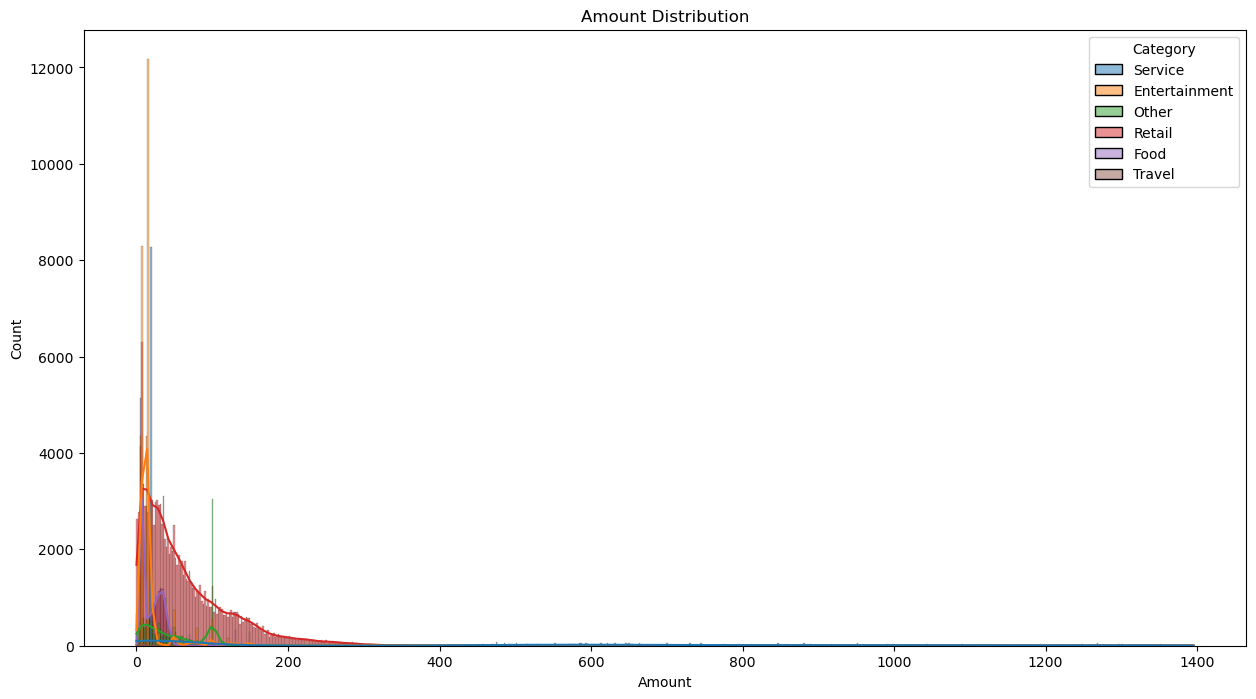

In [18]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=purchase_data, x='Amount', hue='Category' ,kde=True, ax=ax)
ax.set_title("Amount Distribution")

Text(0.5, 1.0, 'Balance Distribution')

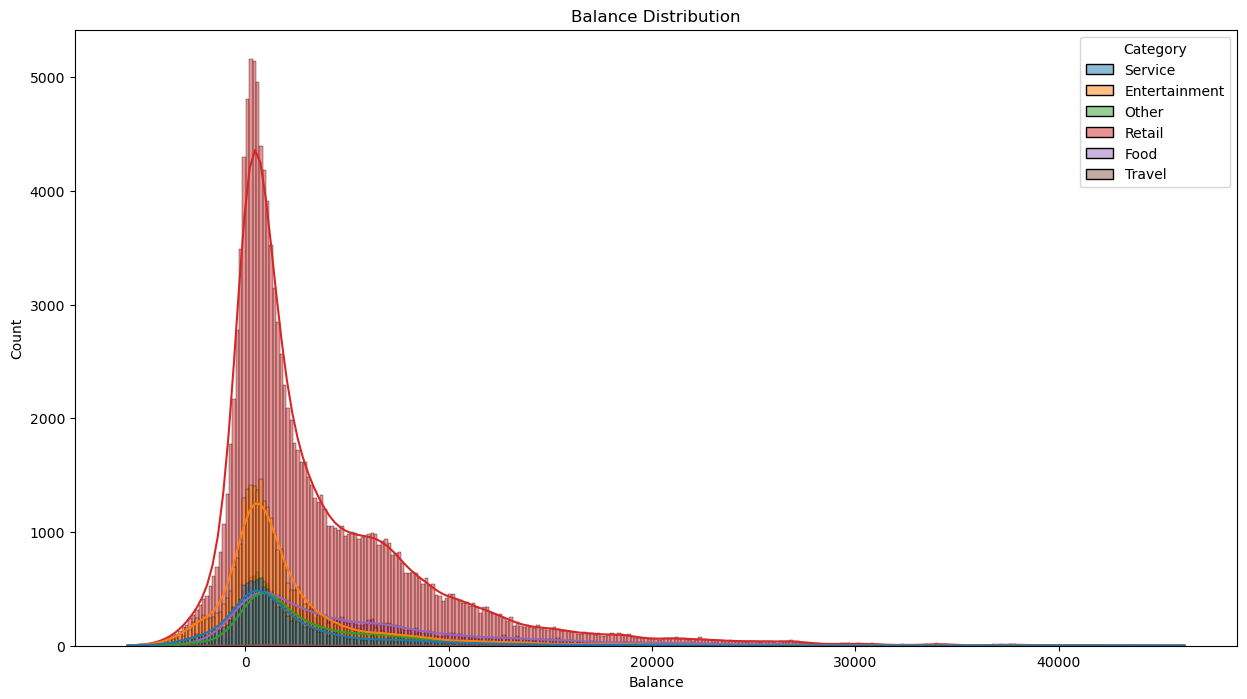

In [19]:
fig, ax = plt.subplots(figsize=(15,8))
hist = sns.histplot(data=purchase_data, x='Balance',  hue='Category' ,kde=True, ax=ax)
ax.set_title("Balance Distribution")

In [20]:
cat_features = ['Hour', 'Month','Day','Account No']
target_feature = 'Category'
cramers = calculate_cramers_v(purchase_data, cat_features, target_feature)
display(cramers)

,Cramers_V,p_value
Hour,0.450713,0.0
Month,0.078143,0.0
Day,0.073853,0.0
Account No,0.276001,0.0


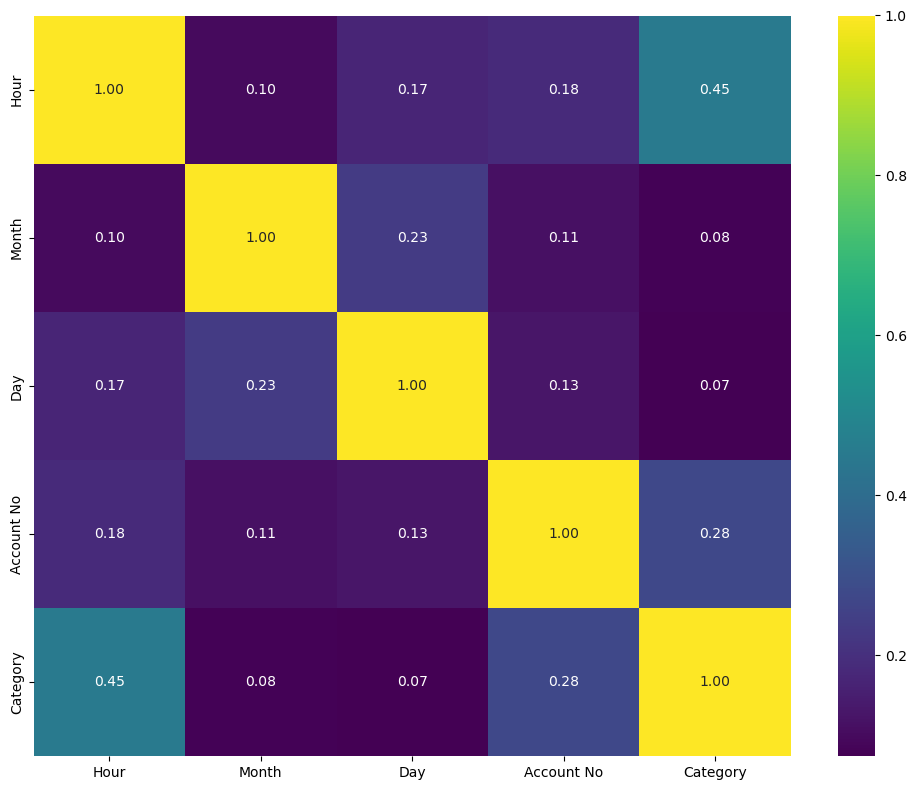

In [21]:
features = ['Hour', 'Month','Day', 'Account No', 'Category']
cramers_v_matrix = calculate_cramers_v_matrix(purchase_data, features)
cramers_v_matrix = cramers_v_matrix.astype(float)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cramers_v_matrix, annot=True, cmap=cm.viridis, fmt='.2f',ax=ax)
plt.tight_layout()
plt.show()

# Model Construction

In [22]:
from catboost import CatBoostClassifier

In [23]:
random_state = 42

In [24]:
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split,cross_val_score
from sklearn.metrics import accuracy_score

In [25]:
cat_features = ['Hour', 'Month','Day','Account No']
X = purchase_data.loc[:, cat_features]
y = purchase_data['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [26]:
model = CatBoostClassifier(task_type='GPU')
model.fit(X_train, y_train, cat_features=cat_features,verbose=0)
model.classes_

array(['Entertainment', 'Food', 'Other', 'Retail', 'Service', 'Travel'],
      dtype=object)

In [27]:
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 50, 300),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 10.0),
#         'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'task_type':'GPU',
#         'devices':'0'
#     }
    
#     model = CatBoostClassifier(**params, random_state=random_state)
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
#     scores = []
    
#     X_param_tuning = X_train.copy()
#     y_param_tuning = y_train.copy()

#     for train_idx, val_idx in cv.split(X_param_tuning, y_param_tuning):
#         X_param_tuning_train, X_val = X_param_tuning.iloc[train_idx], X_param_tuning.iloc[val_idx]
#         y_param_tuning_train, y_val = y_param_tuning.iloc[train_idx], y_param_tuning.iloc[val_idx]

#         model.fit(X_param_tuning_train, y_param_tuning_train,cat_features=cat_features,verbose=0)

#         # Predict on the validation set
#         y_pred = model.predict(X_val)

#         acc = accuracy_score(y_val, y_pred)
#         scores.append(acc)

#     # Return the average AUC score across folds
#     return sum(scores) / len(scores)

In [28]:
y_pred = model.predict(X_test)

In [29]:
y_pred

array([['Retail'],
       ['Service'],
       ['Retail'],
       ...,
       ['Retail'],
       ['Retail'],
       ['Retail']], dtype=object)

In [30]:
len(y_pred[y_pred != 'Retail'])

12990

In [31]:
from sklearn.metrics import f1_score

In [32]:
print(f"f1_score is {f1_score(y_test, y_pred, average='macro')}.")

f1_score is 0.4954156424430272.
